<div style="padding:30px; color: white; background-color: #0071CD">
<center>
<img src="img/logoub.jpeg"></img>
<center>
<h1>Algorísmica Avançada</h1>
<h2>Ramificació i Poda</h2>
</center>
</div>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
from queue import PriorityQueue

# Problema 1: Job Sequencing with deadlines
Suposem que tenim un conjunt de tasques a realitzar, $J_1,\dots,J_n$. Cada una d'elles té assignada una penalització per no realitzar-la a temps $p_1,\dots,p_n$, un temps de durada de la tasca $t_1,\dots,t_n$ i un temps de deadline: $d_1,\dots,d_n$.<br><br>

Implementeu un algoritme que trobi quines tasques hem de realitzar i quines no per a tenir una penalització mínima. La funció ha de retornar les tasques realitzades i la penalització mínima obtinguda (la suma de les tasques que descartem).

Un exemple concret:

| Tasca (Ji)  | 1 | 2 | 3 | 4 | 
| --- | --- | --- | --- | --- |
| Penalització  | 5 | 10 | 6 | 3 | 
| Deadline  | 1 | 3 | 2 | 1 | 
| Temps  | 1 | 2 | 1 | 1 | 

Considerem la notació següent:

Sigui $x$ un node, $S_x$ les tasques agafades en el node $x$:

$$m(x) = \max\{i\ |\ i\in S_x\} \ \ \ \ \ \ \text{És l'última tasca que forma part de la solució}$$
<br>
$$s(x) = \sum_{i\in S_x}t_i \ \ \ \ \ \ \text{És la suma dels temps que tardem a fer les tasques selecionades}$$
<br>
$$d(x) = \max\{d_i\ |\ i\in S_x\} \ \ \ \ \ \ \text{És el deadline màxim de les tasques que formen part de la solució}$$
<br>
$$c(x) = \sum_{i<m,\ i\notin S_x}p_i\ \ \ \ \ \ \text{És el cost de no considerar un seguit de tasques}$$
<br>
$$u(x) = \sum_{i\notin S_x}p_i \ \ \ \ \ \ \text{És la cota superior de les penalitzacions}$$
<br>
$$sup = \infty \ \ \ \ \ \ \text{Aquí guardarem la millor cota trobada fins al moment} $$

Anem a resoldre el problema. A l'acabar, ens ha de quedar un arbre com el següent:

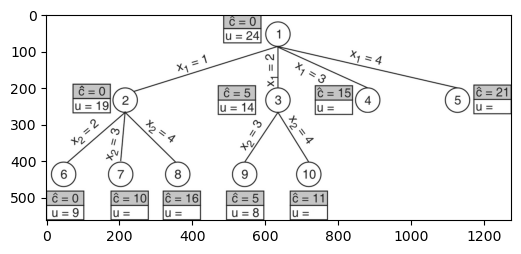

In [2]:
from matplotlib import pyplot as plt
im = plt.imread('img/tree.png')
fig, ax = plt.subplots(figsize=(6, 3))
ax.imshow(im)
plt.show()

Acabeu d'omplir la següent taula d'execució:

| Node  | S_x | m(x) | s(x) | d(x) | c(x) | u(x) | sup |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | {} | - | 0 | 0 | 0 | 5+10+6+3=24 | 24 |
| 2 | {1} | 1 | 1 | 1 | 0 | 10+6+3=19 | 19 |
| 3 | {2} | 2 | 2 | 3 | 5 | 5+6+3=14 | 14 |
| 4 | {3} | 3 | 1 | 2 | 15 | x | x |
| 5 | {4} | 4 | 1 | 1 | 21 | x | x |
| 6 | {1,2} | 2 | 3 | 3 | 0 | 6+3=9 | 9 |
| 7 | {1,3} | 3 | 2 | 2 | 10 | x | x |
| 8 | {1,4} | 4 | 2 | 1 | x | x | x |
| 9 | {2,3} | 3 | 3 | 3 | 5 | 5+3=8 | 8 |
| 10 | {2,4} | 4 | 3 | 3 | 11 | x | x |

Un parell de coses a considerar durant la implementació:
+ Us recomanem guardar 6 variables a la PriorityQueue: $c(x)$, $u(x)$, $S_x$, $s(x)$, $d(x)$ i $m(x)$. Extraureu sempre el node amb cost més baix.
+ A part de considerar les cotes $c(x)$ i $sup$ a l'hora d'afegir un nou node a la PQ, heu de controlar també els temps/deadlines. Una forma fàcil és comprovar que la suma de totes les tasques de la solució $s(x)$ és menor o igual al valor $d(x)$.

In [105]:
def compute_c(jobs, m, Sx):
    """
    Donada la llista de tasques, el valor m i les tasques seleccionades, calcula el valor c(x)
    """
    c = 0
    for tasca in jobs:
        if tasca[0] not in Sx and tasca[0] < m:
            c += tasca[1]
    return c
def compute_u(jobs, Sx):
    """
    Donada la llista de tasques i les tasques seleccionades, calcula el valor u(x)
    """
    u = 0
    for tasca in jobs:
        if tasca[0] not in Sx:
            u += tasca[1]
    return u
def compute_s(jobs, Sx):
    """
    Donada la llista de tasques i les tasques seleccionades, calcula el valor s(x)
    """
    s = 0
    for tasca in jobs:
        if tasca[0] in Sx:
            s += tasca[3]
    return s
def compute_d(jobs, Sx):
    d = 0
    for tasca in jobs:
        if tasca[0] in Sx:
            if tasca[2] > d:
                d = tasca[2]
    return d

def solve_jobs(jobs):
    """
    Soluciona el problema de les tasques
    """
    
    # Millor solució trobada. Inicialment té cota infinit
    sup = np.inf
    best_Sx = None
    
    nodes = [tasca[0] for tasca in jobs]
    # Guardem en una cua de prioritat els nodes
    # Guardarem les variables:
    # 1. Cost, c(x)
    # 2. Cota superior, u(x)
    # 3. Tasques que hem agafat fins al moment, S_x 
    # 4. Suma dels temps de les tasques de S_x, s(x)
    # 5. Màxim dels deadlines de les tasques de S_x, d(x)
    # 6. Valor m(x)
    
    # Inicialitzem la cua de prioritat i els diferents valors que guardarem
    pq = PriorityQueue()
    Sx = []
    m = 0
    s = 0
    d = 0
    c = compute_c(jobs, m, Sx)
    u = compute_u(jobs, Sx)
    
    sup = u
    best_Sx = Sx
    
    #inicialitzem les primeres quatre branques per poder iterar sobre elles
    for Sx in nodes:
        m = Sx
        s = compute_s(jobs,[Sx])
        d = compute_d(jobs,[Sx])
        if d >= s:
            c = compute_c(jobs, m, [Sx])
            u = compute_u(jobs, [Sx])
            if u < sup:
                sup = u
                best_Sx = [Sx]
            pq.put((c, u, [Sx], s, d, m))
            
    while not pq.empty():
        
        # Obtenim un nou element de la cua, el de més baix cost
        current_c, current_u, current_Sx, current_sum, current_d, current_m = pq.get()
        if current_c < sup:
            if current_Sx[-1] in nodes and current_Sx[-1] != len(jobs):
                index = nodes.index(current_Sx[-1])
                Sx = current_Sx + [jobs[index+1][0]]
                m = Sx[-1]
                s = compute_s(jobs,Sx)
                d = compute_d(jobs,Sx)
                if d >= s:
                    c = compute_c(jobs, m, Sx)
                    u = compute_u(jobs, Sx)
                    if u < sup:
                        sup = u
                        best_Sx = Sx
                    pq.put((c, u, Sx, s, d, m))            
            
    return best_Sx, sup

In [106]:
# Retorna ({1, 2}, 0)
jobs = [(1, 10, 3, 2),
        (2, 3, 1, 1)]
solve_jobs(jobs)

([1, 2], 0)

In [107]:
# Retorna ({2, 3}, 8)
jobs = [(1, 5, 1, 1),
        (2, 10, 3, 2),
        (3, 6, 2, 1),
        (4, 3, 1, 1)]
solve_jobs(jobs)

([2, 3], 8)

# Problema 2: Sliding-Puzzle
Donat un taulell de $n\times n$ de nombres des d'$1$ fins a $n^2-1$ inicialment desordenats, volem trobar el nombre mínim de moviments possibles de manera que els nombres estiguin ordenats en ordre creixent i la casella sense número estigui a l'última posició.

<img src="img/Initial-state-and-goal-state-of-8-puzzle.png" width='25%'>

In [2]:
from npuzzle import NPuzzle

# Inicialitzem un tauler i el barregem
board = NPuzzle()
board.create_board(n=3, moves=100)

print ("Un tauler aleatori:")
print(board)

Un tauler aleatori:
+-----------+
| 2 | 3 | 6 | 
+-----------+
| 1 | 4 | 8 | 
+-----------+
|   | 7 | 5 | 
+-----------+



La funció ``get_state_id`` ens retorna un 'string' amb la configuració del tauler. D'aquesta forma podrem guardar els estats que ja hem visitat per a no repetir-los


In [3]:
board.get_state_id()

'2,3,6,1,4,8,0,7,5'

Per a cada tauler, podem definir una cota que depèn del nombre de moviments que hem fet fins al moment i un valor optimista calculat com una 'distància' entre el tauler que estem considerant i el tauler objectiu.

$$C(X) = g(X) + h(X)$$
+ $g(X)$ és el nombre de passos que portem fins el moment.
+ $h(X)$ pot ser:
    + $h_1(X)$: El nombre de caselles que no estan al seu lloc sense tenir en compte la casella buida (hamming_distance)
    + $h_2(X)$: La suma de les distàncies de manhattan de cada casella al seu lloc correcte (manhattan_distance)

In [4]:
board.hamming_distance() # h1(X)

8

In [5]:
board.manhattan_distance() # h2(X)

10

Podem demanar quins moviments són valids des d'una configuració del tauler amb la funció ``allowed_moves()``. Un moviment consisteix en 'moure' la casella buida en una de les quatre direccions permeses:<br>
+ $L$: Left
+ $R$: Right
+ $U$: Up
+ $D$: Down

In [6]:
am = board.allowed_moves()
print(am)

['R', 'U']


Executem un moviment amb la funció ``move()``

In [7]:
new_board = board.move(am[0])
print(new_board)

+-----------+
| 2 | 3 | 6 | 
+-----------+
| 1 | 4 | 8 | 
+-----------+
| 7 |   | 5 | 
+-----------+



La funció state ens comprova si el nostre estat és un estat solució.

In [8]:
# Solucionat: True
# No solucionat: False
new_board.state()

False

In [9]:
def solve_puzzle(board):
    """
    Soluciona el problema del N-Puzzle
    
    Params
    ======
    :board: Un objecte de la classe NPuzzle
    
    Returns
    =======
    :best_bound: Nombre de passos mínims per transformar el tauler d'entrada en el tauler objectiu
    :best_board: El tauler objectiu. Haurien de ser els números ordenats de petit a gran amb la casella buida al final.
    :expanded: El nombre de taulers expandits. Cada cop que traiem un tauler de la cua de prioritat, sumem 1.
    """
    
    # Millor solució trobada. Inicialment té cota infinit
    best_bound = np.inf
    best_board = board
    
    # Guardem en una cua de prioritat els taulells.
    # Guardarem les variables:
    # 1. Distància mínima (cota inferior) entre el tauler actual i el tauler solució
    # 2. Número de passes que duem en aquest tauler, g(X)
    # 3. El tauler
    pq = PriorityQueue()
    pq.put((board.manhattan_distance() + 0, 0, board))
    
    # Com que els estats poden repetir-se al llarg de l'exploració, guardarem en un 'set' tots els
    # estats visitats. Així evidem tornar a visitar estats.
    existent_states = set([board.get_state_id()])
    expanded = 0
    
    while not pq.empty():
        
        # Obtenim un nou element de la cua
        curr_bound, curr_steps, curr_board = pq.get()
        
        if curr_bound < best_bound:
            expanded += 1
        
            am = curr_board.allowed_moves() # veiem quins moviments tenim possibles
            for i in range(len(am)):
                new_board = curr_board.move(am[i]) #fem moviment possible
                new_steps = curr_steps + 1
                new_bound = new_steps + new_board.manhattan_distance() #g(x)+h(x)
                
                if new_board.state() == True:
                    best_board = new_board
                    best_bound = new_bound
                if new_board.get_state_id() not in existent_states:
                    existent_states.add(new_board.get_state_id())
                    pq.put((new_bound, new_steps, new_board))

                
    return best_bound, best_board, expanded

In [16]:
board = NPuzzle()
board.create_board(moves=100, n=3)
print("Tauler inicial:")
print(board)
distance, final_board, expanded = solve_puzzle(board)
print(f"Solucionat en {distance} passos")
print(f"Taulers expandits: {expanded}")
print("Tauler final:")
print(final_board)

Tauler inicial:
+-----------+
| 2 | 1 | 3 | 
+-----------+
| 4 |   | 5 | 
+-----------+
| 7 | 6 | 8 | 
+-----------+

Solucionat en 18 passos
Taulers expandits: 654
Tauler final:
+-----------+
| 1 | 2 | 3 | 
+-----------+
| 4 | 5 | 6 | 
+-----------+
| 7 | 8 |   | 
+-----------+



# Problema 3: Assignació de tasques
Sigui $A$ una matriu de nombres enters de mida $n\times n$:
    $$A = \begin{pmatrix}a_{0,0}\quad \cdots \quad a_{0,n}\\
                         \vdots\quad\quad\quad\quad\vdots\\
                         a_{n,0}\quad \cdots \quad a_{n,n}
         \end{pmatrix}$$
    L'element $a_{i,j}$ correspon al cost d'assignar la tasca $i$ a l'empresa $j$.<br>
    Volem trobar el mínim cost d'assignar tasques a empreses amb la condició que totes les tasques han d'estar assignades i les empreses han de fer només una tasca.
     
</div>

## Funcions útils

In [15]:
costs = np.array([[11,12,18,40],
                  [14,15,13,22],
                  [11,17,19,23],
                  [17,14,20,28]])

####  <u>np.min</u>
Ens permet obtenir el mínim de cada columna o fila d'una matriu

In [16]:
print(costs.min(axis=0)) # Axis=0 indica que volem el mínim de cada columna
print(sum(costs.min(axis=0)))

[11 12 13 22]
58


In [17]:
print(costs.min(axis=1)) # Axis=1 indica que volem el mínim de cada fila
print(sum(costs.min(axis=1)))

[11 13 11 14]
49


#### <u>np.delete</u>
Ens permet eliminar una fila o una columna d'un array de numpy.<br>
Observa els exemples:

In [18]:
# Axis=0 indica que volem eliminar files. En aquest cas estem eliminant només la fila 2
new_costs1 = np.delete(costs, 2, axis=0) 
print(new_costs1)

[[11 12 18 40]
 [14 15 13 22]
 [17 14 20 28]]


In [19]:
# Axis=0 indica que volem eliminar files. En aquest cas estem eliminant les files 0 i 1
new_costs2 = np.delete(costs, [0,1], axis=0) 
print(new_costs2)

[[11 17 19 23]
 [17 14 20 28]]


In [20]:
# Axis=1 indica que volem eliminar columnes. En aquest cas estem eliminant les columnes 0 i 2
new_costs3 = np.delete(costs, [0,2], axis=1)
print(new_costs3)

[[12 40]
 [15 22]
 [17 23]
 [14 28]]


In [21]:
# Podem esborrar files i columnes d'una matriu
new_costs4 = np.delete(np.delete(costs, [0,1], axis=0), [2,3], axis=1)
print(new_costs4)

[[11 17]
 [17 14]]


In [227]:
import copy
def inf_bound(matrix):
    """
    Calcula la suma del mínim de cada columna
    
    Params
    ======
    :matrix: La matriu de costs
    
    Returns
    =======
    :inf: La suma del mínim de cada columna
    """
    cota_inf = sum(matrix.min(axis=0))
    return cota_inf
    
def sup_bound(matrix):
    """
    Retorna el cost d'una assignació qualsevol.
    
    Params
    ======
    :matrix: La matriu de costs
    
    Returns
    =======
    :sup: El cost d'una assignació qualsevol. Per exemple, podem retornar la suma de la diagonal de la matriu
          que consisteix en assignar la tasca 'i' a l'empresa 'i' on i=0,1,2,3,4...
    """
    cota_sup = 0
    for i in range(len(matrix)):
        cota_sup += matrix[i][i]
    return cota_sup

def tasks(matrix):
    """
    Troba l'assignació entre tasques i empreses amb cost mínim utilitzant ramificació i poda.
    Cada cop que troba una assignació millor ll'imprimeix per pantalla.
    
    Params
    =====
    :matrix: La matriu de costs
    """
    
    # Cotes inicials
    sup = sup_bound(matrix)
    inf = inf_bound(matrix)
    best_sup = sup
    best_sol = [(i,i) for i in range(len(matrix))]
    
    # Cua de prioritat. Guardarem quatre elements:
    # 1. Prioritat
    # 2. Parelles ja assignades (tasca, empresa)
    # 3. Tasca que hem d'assignar a continuació (row)
    # 4. Empreses ja assignades (col)
    pq = PriorityQueue()
    pq.put((inf, [], 0, set([])))
    
    # Iterarem mentre la cua de prioritat no sigui buida
    while not pq.empty():
        
        # Extraiem un element
        elem_cota, elem_list, tasca, elem_cols = pq.get()
        
        
        if elem_cota <= sup: #si cota inferior es menor que la solucio ja assegurada explorem el node
            
            for empresa in range(len(matrix)): # per la nova fila mirem les possibles columnes
                if empresa not in elem_cols:
                    
                    new_elem_list = copy.deepcopy(elem_list)
                    new_elem_list.append((tasca, empresa))
                    new_elem_cols = copy.deepcopy(elem_cols)
                    new_elem_cols.add(empresa)
                    
                    new_matrix = np.delete(np.delete(matrix, [i for i in range(tasca+1)], axis=0), [i for i in new_elem_cols], axis=1)
                    inf = 0 
                    sup = 0
                    if len(new_matrix) != 0:
                        inf = inf_bound(new_matrix) # calculem cota inferior de matriu restant
                        sup = sup_bound(new_matrix) # calculem cota superior de matriu restant
                    for tupla in new_elem_list:
                        inf += matrix[tupla[0]][tupla[1]]
                        sup += matrix[tupla[0]][tupla[1]] # afegim a les cotes els valors ja fixats per l'arbre
                    
                    if sup < best_sup: #actualitzem solució si és millor
                        best_sup = sup
                    if tasca < len(matrix)-1:
                        pq.put((inf, new_elem_list, tasca + 1, new_elem_cols))
                    if tasca == len(matrix)-1 and sup == best_sup:
                        best_sol = new_elem_list

    print(f'MILLOR SOLUCIÓ TROBADA:  cost = {best_sup}')
    for tupla in best_sol:
        print(f'TASCA {tupla[0]} --> Empresa {tupla[1]}')

In [228]:
costs = np.array([[11,12,18,40],
                  [14,15,13,22],
                  [11,17,19,23],
                  [17,14,20,28]])

print("Matriu de costs:")
print(costs)
print()

# Millor solució trobada, cost: 61
# Tasca 0 -> Empresa 0
# Tasca 1 -> Empresa 2
# Tasca 2 -> Empresa 3
# Tasca 3 -> Empresa 1

tasks(costs)

Matriu de costs:
[[11 12 18 40]
 [14 15 13 22]
 [11 17 19 23]
 [17 14 20 28]]

MILLOR SOLUCIÓ TROBADA:  cost = 61
TASCA 0 --> Empresa 0
TASCA 1 --> Empresa 2
TASCA 2 --> Empresa 3
TASCA 3 --> Empresa 1


In [229]:
costs = np.array( [[38, 43, 49, 21, 25, 26, 18, 49],
                   [32, 48, 34, 38, 29, 16, 45, 44],
                   [45, 16, 29, 25, 39, 29, 32, 34],
                   [44, 30, 41, 36, 27, 34, 33, 24],
                   [34, 43, 39, 10, 23, 17, 39, 23],
                   [26, 28, 36, 45, 27, 47, 36, 45],
                   [28, 22, 42, 10, 38, 19, 38, 25],
                   [19, 36, 21, 46, 13, 39, 30, 24]])

print("Matriu de costs:")
print(costs)
print()

# Millor solució trobada, cost: 154
# Tasca 0 -> Empresa 6
# Tasca 1 -> Empresa 5
# Tasca 2 -> Empresa 1
# Tasca 3 -> Empresa 7
# Tasca 4 -> Empresa 4
# Tasca 5 -> Empresa 0
# Tasca 6 -> Empresa 3
# Tasca 7 -> Empresa 2

tasks(costs)

Matriu de costs:
[[38 43 49 21 25 26 18 49]
 [32 48 34 38 29 16 45 44]
 [45 16 29 25 39 29 32 34]
 [44 30 41 36 27 34 33 24]
 [34 43 39 10 23 17 39 23]
 [26 28 36 45 27 47 36 45]
 [28 22 42 10 38 19 38 25]
 [19 36 21 46 13 39 30 24]]

MILLOR SOLUCIÓ TROBADA:  cost = 154
TASCA 0 --> Empresa 6
TASCA 1 --> Empresa 5
TASCA 2 --> Empresa 1
TASCA 3 --> Empresa 7
TASCA 4 --> Empresa 4
TASCA 5 --> Empresa 0
TASCA 6 --> Empresa 3
TASCA 7 --> Empresa 2


En aquest cas no us podem donar la solució ja que és un exemple aleatori. Proveu-ho amb diferents mides de matrius.

In [230]:
costs = np.random.randint(10,50,(10,10))

print("Matriu de costs:")
print(costs)
print()

tasks(costs)

Matriu de costs:
[[27 17 38 38 43 19 35 24 26 18]
 [15 36 12 45 12 21 33 39 45 29]
 [19 31 16 10 25 26 29 19 11 19]
 [35 33 13 14 19 29 21 42 46 27]
 [42 42 38 35 43 23 37 30 18 12]
 [31 24 16 32 22 26 32 27 11 25]
 [38 37 39 10 13 16 13 42 49 28]
 [13 29 17 15 29 16 12 28 39 12]
 [22 47 42 31 21 35 10 41 10 22]
 [25 34 26 28 13 14 43 20 19 26]]

MILLOR SOLUCIÓ TROBADA:  cost = 131
TASCA 0 --> Empresa 1
TASCA 1 --> Empresa 4
TASCA 2 --> Empresa 7
TASCA 3 --> Empresa 2
TASCA 4 --> Empresa 9
TASCA 5 --> Empresa 8
TASCA 6 --> Empresa 3
TASCA 7 --> Empresa 0
TASCA 8 --> Empresa 6
TASCA 9 --> Empresa 5
